In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Runs multiple output commands in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%run -i 'DataLoader.py'

In [4]:
# %run -i 'Datapreprocessing.py'

In [ ]:
monthly_data = train.groupby(['shop_id','item_id','date_block_num']).agg({'item_cnt_day':'sum','item_price':'mean'}).reset_index(); # groupby automatically removes the column not mentioned, reset_index doesn't make the groupby columns as index
monthly_data = monthly_data.rename(columns={'date_block_num':'month_block_num','item_price':'mean_item_price','item_cnt_day':'item_cnt_month'});
# Combining all test points
monthly_data = pd.merge(test,monthly_data,on=['shop_id','item_id'],how='left') 
# Filling NaN
monthly_data=monthly_data.fillna(0)
# Sorting
monthly_data.sort_values(by=['shop_id','item_id','month_block_num'])
# Clipping
monthly_data['item_cnt_month'] = monthly_data['item_cnt_month'].clip(0,20)
# Combining all info in monthly_data table
monthly_data = pd.merge(monthly_data,items,on=['item_id'],how='inner')
monthly_data = pd.merge(monthly_data,categories,on=['item_category_id'],how='inner')
monthly_data = pd.merge(shops,monthly_data,on=['shop_id'],how='inner')

In [ ]:
# Doing the same stuff for test
test_modified = pd.merge(test,items, on = ['item_id'],how='inner')
test_modified['month_block_num'] = 34
test_modified = test_modified.drop(['item_name'], axis=1)
test_modified = test_modified.set_index('ID')

In [5]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702955 entries, 0 to 702954
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shop_name           702955 non-null  object 
 1   shop_id             702955 non-null  int64  
 2   ID                  702955 non-null  int64  
 3   item_id             702955 non-null  int64  
 4   month_block_num     702955 non-null  float64
 5   item_cnt_month      702955 non-null  float64
 6   mean_item_price     702955 non-null  float64
 7   item_name           702955 non-null  object 
 8   item_category_id    702955 non-null  int64  
 9   item_category_name  702955 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 59.0+ MB


In [6]:
import xgboost as xgb

In [7]:
train_X_xgb = monthly_data[['shop_id','item_id','item_category_id','month_block_num']]
train_y_xgb = monthly_data[['item_cnt_month']]

In [8]:
model = xgb.XGBRegressor(max_depth = 10, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1)

In [9]:
model.fit(train_X_xgb, train_y_xgb, eval_metric='rmse')

[21:04:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, num_round=1000,
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

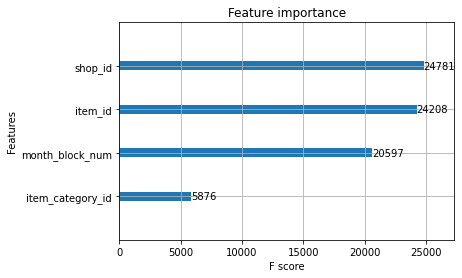

In [10]:
xgb.plot_importance(model); # this is based on importance type being weight (#times a feature appears in a tree)

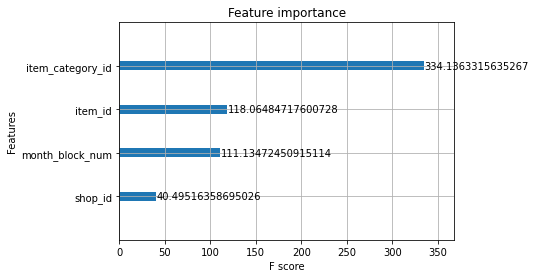

In [11]:
xgb.plot_importance(model,importance_type="gain"); # average gain of splits which use the feature

In [12]:
predictions = model.predict(test_modified) # Here we need to ensure that the order of the columns also match

In [13]:
pred_dataframe = pd.DataFrame(predictions, columns = ['item_cnt_month'])
pred_dataframe['item_cnt_month'] = pred_dataframe['item_cnt_month'].clip(0,20)

In [14]:
pred_dataframe.to_csv('xgb_baseline.csv',index=True,index_label='ID') #index is False to not write index as a column in the csv file

In [15]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0
